# MNIST GAN (adapted from a tutorial from Tensorflow)


Name: Rahmani Dibansa

Date: 25th of August 2022

Description:
    This contains my output for the homework on lecture 7
Description Edit:
    This contains my comments on how I understood GAN or Generative Adversial Network
    

Reference(s):
    ACMSIGGRAPH. SIGGRAPH Now | Hands-on Workshop: Machine Learning and Neural Networks – Lecture 7

    Retrieved from: https://www.youtube.com/watch?v=MC9mLYrTCsM&list=PLUPhVMQuDB_b2kcOooEduedthcBH53mvC&index=7


Additional Comments:
- Basically, the generative adversial network uses a training dataset so that it can learn to generate an image that looks similar to the inputs. If used in an image dataset, it will generate an image that looks authentic. As such, this can be used to artificially generate new faces

- To make this possible, the GAN has two main components. One is the generator, this is responsible for generating noise that will eventually look authentic enough. The second part is a classifier/discriminator that checks whether the generated noise looks authentic.


In [1]:
# Import the tensorflow package
import tensorflow as tf

In [2]:
# check the version
tf.__version__

'2.8.2'

In [3]:
# To generate GIFs
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [8]:
# Load the mnist data set and take
# the training images along with the labels
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [9]:
# Prepare the training data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [10]:
# Set the buffer size and the batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the take the batch
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
# This is for building the model for the generator part
# of the Generative Adversial Network
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Additional comments:
#     - The model with generate the input noise
#     - Then, it will normalize the batch
#     - After that, it will use the LeakyReLU
#     - It will reshape the noise that has been generated
#       and use the transposed version of a convolutional layer with 128 nodes
#       to keep up sampling until the desired 28*28 grayscale image has been
#       produced

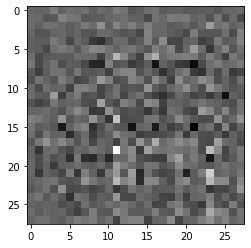

In [15]:
# Use the generator model
generator = make_generator_model()

# generate noise
noise = tf.random.normal([1, 100])

# sanity check
generated_image = generator(noise, training=False)

# display the noise
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [16]:
# discriminator is just a simple classifier
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Drop some of the nodes for efficiency

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [17]:
# sanity check
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00225204]], shape=(1, 1), dtype=float32)


In [20]:
# This method returns a helper function to compute cross entropy loss
# The binary cross entropy is used because we are doing image classification
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
# Basically, this just switches the loss
# For the discriminator, its loss is the gain of the generator
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
# We want the generator to succeed while the discriminator to lose
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
# save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 15
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Generate 256 random noise 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Use the noise to generate an image for training
      generated_images = generator(noise, training=True)

      # Check whether the generated image(fake output) looks authentic
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [30]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [31]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

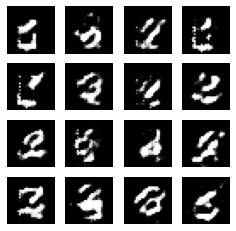

In [32]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [33]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

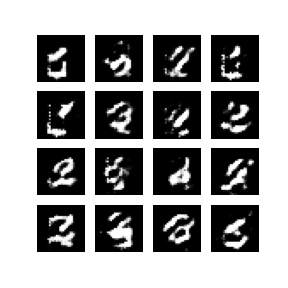

In [34]:
display_image(EPOCHS)